感谢大家来我的网站学习https://www.captainbed.net

PS:本文档带你学习的是tensorflow的1.x版本。tensorflow2.x版本已经与1.x版本有很大不同了。

激动人心的时刻来了！本篇文章我带领大家使用tensorflow框架来构建一个完整的人工智能程序。这个程序可以识别手语！这样就可以帮助聋哑人士和其他人能更好的进行交流了！

In [16]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt

# 因为我们安装的是tensorflow2.x，所以要想使用1.x代码的话，就需要使用下面的两行代码。
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()
# 如果安装的是tensorflow1.x，那么就直接使用下面的一行代码
#import tensorflow as tf

from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)

通过前面几篇文章的学习，我们明白了tensorflow程序大致有两个大步骤构成：

- 创建/设计一些操作，这些操作构成一个计算图
- 执行前面设计的计算图

在用tensorflow构建一个完整的人工智能程序时，我们会遇到各种问题。下面我带领大家来一一解决它们！

### 手语数据库

为了让程序能识别手语，首先需要解决的问题就是要构建一个手语数据库来让AI程序进行学习。为了方便教学，所以将数据量定得比较小，因为数据量太大的话，训练的时间就太久，不适合教学目的。

- **训练数据集**: 1080张图 (64 * 64像素)，它们表示了0到5的数字。每一个数字有180张不同的图像，这些图像虽然都表示同一个数字，但是它们都稍微有所不同，或者是展示人的手不同。
- **测试数据集**: 120张图 (64 * 64像素)，它们当然也表示0到5的数字。 每一个数字有20张不同的图像。

本例的数据集中只有5个手势，完整的数据集中有很多手势。

下面给出了每一个数字所对应的一个手势图。这是还没有缩放成64 * 64像素的原图。
<img src="images/hands.png" style="width:800px;height:350px;"><caption><center> <u><font color='purple'> 图 1</u><font color='purple'>: 手语数据库<br> <font color='black'> </center>


加载数据集的代码我已经帮大家在工具库中实现了。下面我们调用它来加载这些手语数据集。

In [17]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

下面的代码是从数据集中挑选一个元素来展示，展示了图片以及它对应的标签。index为0就表示取第一个元素，这个元素的图像表示的手势是5。你也可以改变index的值，来展示展示其它元素。

y = 5


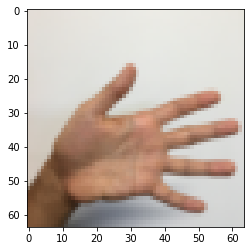

In [18]:
index = 0
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

如我们教程中前面学到的知识一样，我们首先将图像数据集进行扁平化处理，然后再除以255来进行一个简单的归一化处理。然后，根据我们在上一个教学里学到的知识，我们用tensorflow来对标签进行one hot编码。

In [19]:
# 扁平化
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
# 简单的归一化
X_train = X_train_flatten / 255.
X_test = X_test_flatten / 255.
# one hot编码
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print("number of training examples = " + str(X_train.shape[1]))
print("number of test examples = " + str(X_test.shape[1]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


**注意** 12288是由$64 \times 64 \times 3$得到的. 因为每个图像都是64 * 64个像素，再乘以3是因为每个像素都是由RGB红绿蓝3个颜色构成的。这些知识我在教程的《1.2.1 如何将数据输入到神经网络中》已经给大家介绍过了。

**我们的目的**就是要构建一个人工智能程序来学习上面的数据，让这个AI程序能够很准确地识别0到5的手语。为了实现这个目的，我们将用tensorflow来构建一个神经网络模型，这个模型与我们之前用纯python构建的很相似。这样一来，有助于大家来对比纯python实现和tensorflow实现的区别。

**模型**的大致结构是*LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX*. 这里我们用到了softmax层，它取代了我们之前一直用着的sigmoid层。

### 创建占位符

第一个任务就是要为`X`和`Y`创建相应的占位符。这样一来，在后面我们执行计算图时，就可以把训练集的数据填充到tensorflow计算图中了。

In [20]:
def create_placeholders(n_x, n_y):
    """
    参数:
    n_x -- 图片向量的大小，本例中是12288
    n_y -- 类别数量，因为是0到5的数字，所以数量是6
    """

    ### 注意下面代码中，样本数量的位置我们填写的是None，因为在执行训练时，用到的样本数量是不同的。
    X = tf.placeholder(tf.float32, [n_x, None], name="X")
    Y = tf.placeholder(tf.float32, [n_y, None], name="Y")
    
    return X, Y

In [21]:
X, Y = create_placeholders(12288, 6)
print("X = " + str(X))
print("Y = " + str(Y))

X = Tensor("X_1:0", shape=(12288, None), dtype=float32)
Y = Tensor("Y_1:0", shape=(6, None), dtype=float32)


### 初始化参数

第二个任务就是用tensorflow来初始化神经网络模型的参数w和b。

In [22]:
def initialize_parameters():
    
    # 将tensorflow中的随机数种子设为1，这样可以确保我们每次执行代码时随机数都是一样的。
    # 如果随机数不一样，那么我执行代码的结果与你们执行的结果就会不一样。
    tf.set_random_seed(1)  
        
    # 我们用tensorflow内置的xavier_initializer函数来进行w的初始化。
    # 教程前面我曾专门花了一篇文章来给大家介绍参数的初始化。
    # 初始化步骤非常重要，好的初始化可以让神经网络学得很快。
    # 之前我们用纯python时，为了实现高质量的参数初始化，需要写不少代码。
    # 而tensorflow已经给我们实现了高效的函数，我们只需要用一行代码调用它就可以对w进行初始化了。
   
    W1 = tf.get_variable("W1", [25, 12288],  initializer = tf.truncated_normal_initializer(stddev=0.1))
    #W1 = tf.get_variable("W1", [25, 12288], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    # 我们将b初始化为0
    b1 = tf.get_variable("b1", [25, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 25], initializer = tf.truncated_normal_initializer(stddev=0.1))
    #W2 = tf.get_variable("W2", [12, 25], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [12, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [6, 12], initializer = tf.truncated_normal_initializer(stddev=0.1))
    #W3 = tf.get_variable("W3", [6, 12], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [6, 1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [23]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters()
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))

W1 = <tf.Variable 'W1:0' shape=(25, 12288) dtype=float32>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32>
W2 = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32>
b2 = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32>


### 实现前向传播

下面这个函数用tensorflow实现了神经网络的前向传播。

In [24]:
def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # 计算第一层的z
    Z1 = tf.add(tf.matmul(W1, X), b1)   
    # 在第一层的z上面执行relu激活操作，得到第一层的a。
    # 注意，tensorflow中已经帮我们实现了relu函数。
    # 之前是我们自己写不少python代码才能实现relu操作的。
    A1 = tf.nn.relu(Z1)                                   
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     
    A2 = tf.nn.relu(Z2)                                    
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     
    
    # 学得好的同学可能会觉得奇怪，为什么这里不计算A3呢？
    # 因为这也是tensorflow的一个特性，它会在计算成本函数时顺带把A3给我们计算了，
    # 所以前向传播中我们只需要计算Z3就可以了。
    return Z3

In [25]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(12288, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    print("Z3 = " + str(Z3))

Z3 = Tensor("Add_2:0", shape=(6, None), dtype=float32)


我们在用纯python时，前向传播会缓存一些数据，好便于后面执行反向传播计算。但是这里为什么没有缓存数据呢？因为这也是tensorflow的一个特性，在下面我们介绍反向传播时你就明白了！

### 计算cost成本

前一个教学已经给大家介绍了如何使用下面的代码来计算神经网络的cost成本:
```python
tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ..., labels = ...))
```
- "`logits`"是最后一层输出的z，"`labels`"是真实标签，在本例中它们分别为Z3和Y。
- `tf.reduce_mean`是获取张量中所有元素的平均值，这里是指每个样本的平均值

In [26]:
def compute_cost(Z3, Y):
    
    # transpose表示转置操作，所以logits相当于Z3.T
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

In [27]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(12288, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    print("cost = " + str(cost))

cost = Tensor("Mean:0", shape=(), dtype=float32)


### 反向传播和参数更新

使用tensorflow框架，我们只需要一行代码就可以完成反向传播和参数更新了。可以用六个字来形容——好邪恶！好强大！

我们只需要创建一个"`optimizer`" 实例对象。这个实例对象可以指定优化算法，例如可以指定是用标准的梯度下降算法还是用adam梯度下降算法；还需要指定学习率以及与哪一个cost函数合作。

例如下面这行代码就创建了一个使用标准梯度下降算法的"`optimizer`" 实例对象:
```python
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
```

上面是定义了"`optimizer`" 操作，下面的语句是执行"`optimizer`" 操作:
```python
_ , c = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
```

这行代码执行时，会将子训练集minibatch_X和minibatch_Y传入到计算图中，计算图会使用指定的优化算法和cost成本函数来进行反向传播并在内部将参数给更新了。一切都发生在内部，表面风平浪静，内部却是波涛汹涌！

**注意** 但我们在写代码时，如果不需要某个返回值，我们就用`_`来代替。上面代码中我们就不需要返回第一个结果，只需要第二个结果c，它代表了cost成本值。

### 构建完整的模型

好，上面我们将各个部件都介绍了，现在，我们将它们组合起来构建成一个完整的神经网络模型。

In [28]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
              
    ops.reset_default_graph()# 将计算图返回到默认空状态
    tf.set_random_seed(1) 
    seed = 3      
    (n_x, m) = X_train.shape # (n_x: 特征数量, m : 训练集中的样本数)
    n_y = Y_train.shape[0] 
    costs = []   
    
    # 创建占位符
    X, Y = create_placeholders(n_x, n_y)

    # 初始化参数
    parameters = initialize_parameters()
    
    # 构建前向传播操作
    Z3 = forward_propagation(X, parameters)
    
    # 构建成本计算操作
    cost = compute_cost(Z3, Y)
    
    # 构建反向传播，为反向传播指定优化算法和学习率以及成本函数，这里我们使用adam算法，
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # 定义初始化操作
    init = tf.global_variables_initializer()

    # 开始一个tensorflow的session
    with tf.Session() as sess:
        
        # 执行初始化操作
        sess.run(init)
        
        # 执行epochs指定的训练次数，一个epoch就是完整的向整个数据集学习一次
        for epoch in range(num_epochs):

            epoch_cost = 0.                       
            num_minibatches = int(m / minibatch_size) # 计算有多少个子训练集
            seed = seed + 1
            # 将数据集分成若干子训练集
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            # 循环遍历每一个子训练集
            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                
                # 这行代码会使整个计算图被执行，从前向传播操作到反向传播操作，最后到参数更新操作。
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                                
                epoch_cost += minibatch_cost / num_minibatches

            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # 画出cost成本的走势图
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # 从计算图中获取训练好了的参数，后面我们就可以用这些参数来识别手语了！
        parameters = sess.run(parameters)
        print("Parameters have been trained!")

        # 分别计算一下在训练集和测试集上面的预测精准度
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

运行下面的代码来训练我们的模型吧！它可能要运行个5分钟左右。这已经算时间短了，因为我们只使用了一小部分手语数据集，如果用完整的数据集，那就时间很长了~~

Cost after epoch 0: 1.859356
Cost after epoch 100: 0.797117
Cost after epoch 200: 0.459786
Cost after epoch 300: 0.269190
Cost after epoch 400: 0.155759
Cost after epoch 500: 0.079337
Cost after epoch 600: 0.046178
Cost after epoch 700: 0.021931
Cost after epoch 800: 0.008391
Cost after epoch 900: 0.004791
Cost after epoch 1000: 0.002244
Cost after epoch 1100: 0.001133
Cost after epoch 1200: 0.000872
Cost after epoch 1300: 0.000496
Cost after epoch 1400: 0.000406


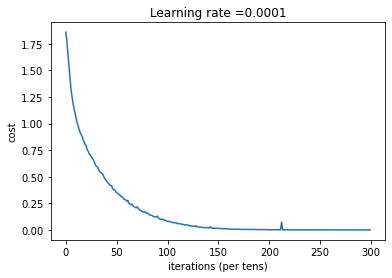

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 0.8833333


In [29]:
parameters = model(X_train, Y_train, X_test, Y_test)

结果还不错！用这么一个小程序就可以让手语识别的准确度达到了88.3%。

如果你看不懂本篇文章，那么你需要学习我教程前面的文章。

本篇文章还只是构建了一个简单的人工智能程序，后面我会带领大家构建更加强大的AI程序！